In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
mal = pd.read_csv('Malaria screener.csv')

In [3]:
mal.head()

,DHSID,GPS_Dataset,DHSCC,DHSYEAR,DHSCLUST,SurveyID,All_Population_Count_2000,All_Population_Count_2005,All_Population_Count_2010,All_Population_Count_2015,...,UN_Population_Density_2000,UN_Population_Density_2005,UN_Population_Density_2010,UN_Population_Density_2015,UN_Population_Density_2020,Wet_Days_2000,Wet_Days_2005,Wet_Days_2010,Wet_Days_2015,Wet_Days_2020
0,NG202100000001,NGGE81FL,NG,2021,1,NG2021MIS,4383.732422,10511.250980,15821.37695,12767.423830,...,122.340126,137.952301,156.200867,176.804611,198.476639,7.454952,7.298984,7.694158,7.095560,7.626615
1,NG202100000002,NGGE81FL,NG,2021,2,NG2021MIS,10095.720700,13841.389650,15144.12500,17101.576170,...,328.920227,370.894653,419.957245,475.351868,533.618652,7.029486,6.815495,7.203261,6.596217,7.128038
2,NG202100000003,NGGE81FL,NG,2021,3,NG2021MIS,34067.722660,44976.214840,55211.96875,55673.691410,...,175.446625,197.835861,224.005936,253.553528,284.633148,8.311914,8.184244,8.568884,8.013810,8.531879
3,NG202100000004,NGGE81FL,NG,2021,4,NG2021MIS,4087.095947,5683.123535,6247.22168,9392.799805,...,155.192780,174.997360,198.146332,224.282898,251.774643,8.987461,8.872630,9.269448,8.747023,9.237495
4,NG202100000005,NGGE81FL,NG,2021,5,NG2021MIS,543.357239,545.644714,962.36676,1112.796753,...,62.213058,70.152237,79.432098,89.909622,100.930397,6.834844,6.670360,6.903941,6.319201,6.890534


In [4]:
mal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Columns: 135 entries, DHSID to Wet_Days_2020
dtypes: float64(123), int64(8), object(4)
memory usage: 598.1+ KB


In [5]:
mal.columns.tolist()

['DHSID',
 'GPS_Dataset',
 'DHSCC',
 'DHSYEAR',
 'DHSCLUST',
 'SurveyID',
 'All_Population_Count_2000',
 'All_Population_Count_2005',
 'All_Population_Count_2010',
 'All_Population_Count_2015',
 'All_Population_Count_2020',
 'Aridity_2000',
 'Aridity_2005',
 'Aridity_2010',
 'Aridity_2015',
 'Aridity_2020',
 'Day_Land_Surface_Temp_2000',
 'Day_Land_Surface_Temp_2005',
 'Day_Land_Surface_Temp_2010',
 'Day_Land_Surface_Temp_2015',
 'Day_Land_Surface_Temp_2020',
 'Diurnal_Temperature_Range_2000',
 'Diurnal_Temperature_Range_2005',
 'Diurnal_Temperature_Range_2010',
 'Diurnal_Temperature_Range_2015',
 'Diurnal_Temperature_Range_2020',
 'Drought_Episodes',
 'Elevation',
 'Enhanced_Vegetation_Index_2000',
 'Enhanced_Vegetation_Index_2005',
 'Enhanced_Vegetation_Index_2010',
 'Enhanced_Vegetation_Index_2015',
 'Enhanced_Vegetation_Index_2020',
 'Frost_Days_2000',
 'Frost_Days_2005',
 'Frost_Days_2010',
 'Frost_Days_2015',
 'Frost_Days_2020',
 'Global_Human_Footprint',
 'Growing_Season_Length'

In [6]:
# Selection of features. Features that were strongly correlated with malaria prevalence were selected

pd.set_option('display.max_rows',567)
correlations = mal.corr()
print(correlations['Malaria_Prevalence_2020'].sort_values(ascending=False))

Malaria_Prevalence_2020           1.000000
Malaria_Incidence_2020            0.948468
Malaria_Prevalence_2005           0.766118
Enhanced_Vegetation_Index_2005    0.668044
Enhanced_Vegetation_Index_2000    0.667497
Enhanced_Vegetation_Index_2015    0.663037
Enhanced_Vegetation_Index_2010    0.657760
Enhanced_Vegetation_Index_2020    0.644609
Wet_Days_2000                     0.585939
Malaria_Prevalence_2000           0.580782
Temperature_January               0.575995
Growing_Season_Length             0.569691
Wet_Days_2015                     0.569533
Wet_Days_2010                     0.565684
Wet_Days_2005                     0.555895
Temperature_December              0.555140
Malaria_Incidence_2005            0.553630
Wet_Days_2020                     0.528238
Aridity_2010                      0.510739
Aridity_2000                      0.508837
Temperature_February              0.507815
ITN_Coverage_2000                 0.505325
Aridity_2015                      0.494823
Precipitati

In [7]:
# Select relevant features for malaria risk prediction. 
# Includes variables relevant to malaria risk like economic activity, population density, ITN coverage, and climatic factors.

selected_features = [
    'Malaria_Prevalence_2020',  # Target variable
    'Nightlights_Composite',   # Proxy for economic activity
    'UN_Population_Density_2020',  # Population density
    'Travel_Times',  # Access to healthcare
    'ITN_Coverage_2020',  # Insecticide-treated net coverage
    'Rainfall_2015',  # Environmental factor
    'Minimum_Temperature_2020', # Climatic factor
    'Malaria_Incidence_2020',
    'Temperature_January',
    'PET_2020',
    'Day_Land_Surface_Temp_2005'
]

In [8]:
# Subset the data
analysis_mal = mal[selected_features]

In [9]:
# Check for missing values in the selected columns
missing_values = analysis_mal.isnull().sum()

# Drop rows with missing values for simplicity
analysis_mal_clean = analysis_mal.dropna()

# Display summary of the cleaned dataset
analysis_mal_clean.describe(), missing_values

(       Malaria_Prevalence_2020  Nightlights_Composite  \
 count               565.000000             565.000000   
 mean                  0.271497               1.364707   
 std                   0.128821               3.631040   
 min                   0.052831               0.000000   
 25%                   0.183608               0.000000   
 50%                   0.258545               0.046538   
 75%                   0.339939               1.031621   
 max                   0.691903              44.810242   
 
        UN_Population_Density_2020  Travel_Times  ITN_Coverage_2020  \
 count                  565.000000    565.000000         565.000000   
 mean                  1097.117769     26.333602           0.388048   
 std                   2986.295617     45.756053           0.197917   
 min                     25.978039      0.000000           0.057542   
 25%                    167.933380      4.137695           0.229241   
 50%                    348.567993     13.836914  

In [10]:
# Remove Outliers
# Define a function to remove outliers based on the IQR method
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Remove outliers from the selected columns
analysis_mal_clean = remove_outliers(analysis_mal_clean, selected_features)

In [11]:
# Prepare Features and Target
x = analysis_mal_clean.drop('Malaria_Prevalence_2020', axis=1)
y = analysis_mal_clean['Malaria_Prevalence_2020']

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(x)

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Train Models

# Linear Regression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [15]:
# Random Forest Regressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [16]:
# Gradient Boosting Regressor

gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [17]:
# Evaluate Models
# Models are evaluated using MSE and R-squared metrics.
models = {
    'Linear Regression': lr,
    'Random Forest': rf,
    'Gradient Boosting': gb
}

In [18]:
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - MSE: {mse:.4f}, R-squared: {r2:.4f}")

Linear Regression - MSE: 0.0006, R-squared: 0.9605
Random Forest - MSE: 0.0003, R-squared: 0.9816
Gradient Boosting - MSE: 0.0003, R-squared: 0.9803


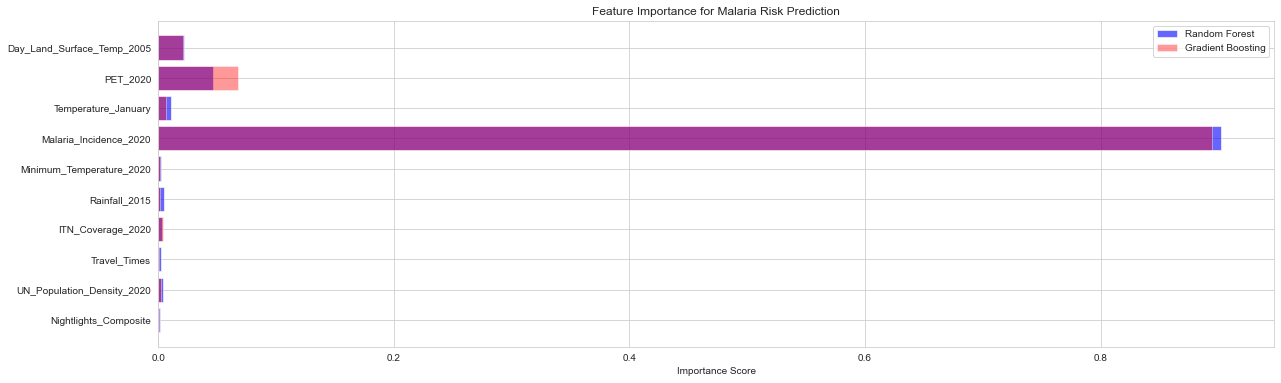

In [19]:
# Feature Importance Analysis (for Random Forest and Gradient Boosting)
# Provides insight into which features contribute most to predictions.

sns.set_style("whitegrid")
rf_feature_importance = rf.feature_importances_
gb_feature_importance = gb.feature_importances_

# Plot Feature Importance
features = x.columns
plt.figure(figsize=(20, 6))
plt.barh(features, rf_feature_importance, color='blue', alpha=0.6, label='Random Forest')
plt.barh(features, gb_feature_importance, color='red', alpha=0.4, label='Gradient Boosting')
plt.title("Feature Importance for Malaria Risk Prediction")
plt.xlabel("Importance Score")
plt.legend()
plt.show()

In [20]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (304, 10)
X_test shape: (76, 10)
y_train shape: (304,)
y_test shape: (76,)


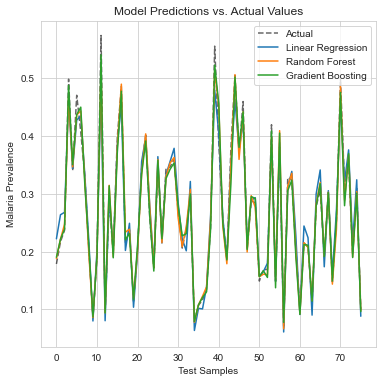

In [21]:
# Visualize Predictions
plt.figure(figsize=(6, 6))
plt.plot(y_test.values, label='Actual', color='black', alpha=0.6, linestyle='dashed')
for model_name, model in models.items():
    plt.plot(model.predict(X_test), label=model_name)
plt.title("Model Predictions vs. Actual Values")
plt.xlabel("Test Samples")
plt.ylabel("Malaria Prevalence")
plt.legend()
plt.show()

In [22]:
yintercept = '%.2f' % lr.intercept_
NC = '%.2f NC' % lr.coef_[0]
PD = '%.4f PD' % lr.coef_[1]
TT = '%.4f TT' % lr.coef_[2]
ITN = '%.2f ITN' % lr.coef_[3]
RF = '%.4f RF' % lr.coef_[4]
MT = '%.4f MT' % lr.coef_[5]
MI = '%.2f MI' % lr.coef_[6]
TJ = '%.4f TJ' % lr.coef_[7]
PET = '%.2f PET' % lr.coef_[8]
DLS = '%.4f DLS' % lr.coef_[9]
print('MalPre = ' + ' ' + yintercept + ' ' + NC + ' ' + PD + ' ' + TT + ' ' + ITN + ' ' + RF + ' ' + MT + ' ' + MI + ' ' + TJ + ' ' + PET + ' ' + DLS)

MalPre =  0.26 -0.00 NC 0.0053 PD -0.0033 TT 0.00 ITN -0.0070 RF 0.0062 MT 0.10 MI -0.0269 TJ -0.04 PET -0.0115 DLS


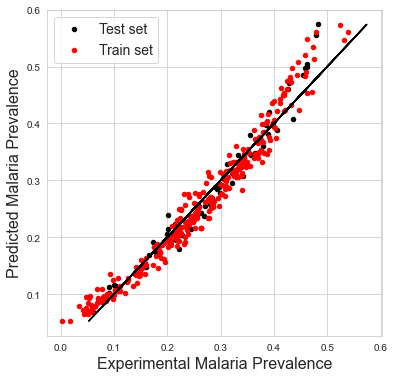

In [23]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(lr.predict(X_test), y_test, s=20, color='black', label = 'Test set')
ax.scatter(lr.predict(X_train), y_train, s=20, color='red', label = 'Train set')
ax.plot(y_test, y_test, color='black')
ax.plot(y_train, y_train, color='black')
plt.legend(fontsize=14)
ax.set_xlabel('Experimental Malaria Prevalence', fontsize=16)
ax.set_ylabel('Predicted Malaria Prevalence', fontsize=16);

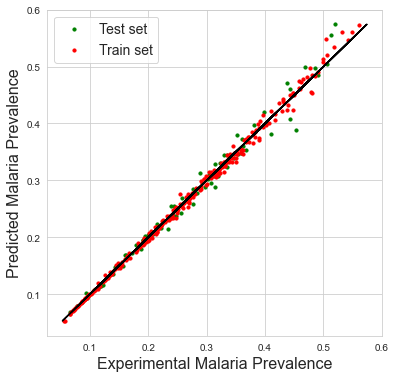

In [24]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(rf.predict(X_test), y_test, s=10, color='green', label = 'Test set')
ax.scatter(rf.predict(X_train), y_train, s=10, color='red', label = 'Train set')
ax.plot(y_test, y_test, color='black')
ax.plot(y_train, y_train, color='black')
plt.legend(fontsize=14)
ax.set_xlabel('Experimental Malaria Prevalence', fontsize=16)
ax.set_ylabel('Predicted Malaria Prevalence', fontsize=16);

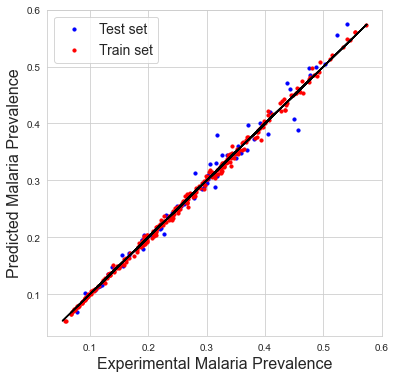

In [25]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(gb.predict(X_test), y_test, s=10, color='blue', label = 'Test set')
ax.scatter(gb.predict(X_train), y_train, s=10, color='red', label = 'Train set')
ax.plot(y_test, y_test, color='black')
ax.plot(y_train, y_train, color='black')
plt.legend(fontsize=14)
ax.set_xlabel('Experimental Malaria Prevalence', fontsize=16)
ax.set_ylabel('Predicted Malaria Prevalence', fontsize=16);

In [26]:
# Add a constant for the intercept in regression
X = sm.add_constant(X)

# Fit an Ordinary Least Squares (OLS) regression model
model = sm.OLS(y, X).fit()

# Display regression results
print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     Malaria_Prevalence_2020   R-squared:                       0.959
Model:                                 OLS   Adj. R-squared:                  0.958
Method:                      Least Squares   F-statistic:                     864.0
Date:                     Mon, 27 Jan 2025   Prob (F-statistic):          4.10e-249
Time:                             16:43:54   Log-Likelihood:                 875.37
No. Observations:                      380   AIC:                            -1729.
Df Residuals:                          369   BIC:                            -1685.
Df Model:                               10                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co